In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D,
    MaxPooling1D,
    LSTM,
    Bidirectional,
    Dropout,
    Flatten,
    Dense,
    Input,
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
from tensorflow.keras.metrics import AUC

from utils import load_dataset, train, plot_roc, auc
from einops import rearrange
import matplotlib.pyplot as plt
import numpy as np

[Reference](https://github.com/uci-cbcl/DanQ/blob/master/DanQ_train.py) 

In [2]:
clear_session()
model = Sequential(
    [
        Input((1000, 4)),
        Conv1D(200, kernel_size=26, activation="relu"),
        MaxPooling1D(pool_size=13, strides=13),
        Dropout(0.2),
        Bidirectional(LSTM(220, return_sequences=True)),
        Dropout(0.5),
        Flatten(),
        Dense(1024, activation="relu"),
        Dense(31, activation="sigmoid"),
    ],
    name="danq_FOX",
)
model.summary()

Model: "danq_FOX"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 975, 200)          21000     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 75, 200)           0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 200)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 75, 440)           740960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 440)           0         
_________________________________________________________________
flatten (Flatten)            (None, 33000)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              337

In [10]:
X_train, y_train, X_test, y_test = load_dataset(
    file="FOX_3000",
    out_dir="/home/victor/Documents/datasets",
    labels="binlabels"
)

X_train = rearrange(X_train, "w h c -> w c h")
X_test = rearrange(X_test, "w h c -> w c h")

In [4]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.math import exp

def scheduler(epoch, lr):
    if epoch < 10:
        return lr

    return lr * exp(-0.1)

lr_schedule = LearningRateScheduler(scheduler)

In [5]:
es = EarlyStopping(monitor="val_loss", patience=10)
optimizer = Adam(lr=1e-3)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=[AUC(multi_label=True), "acc"],
)

Epoch 1/60
10000/10000 - 427s - loss: 0.1595 - auc: 0.7125 - acc: 0.2208 - val_loss: 0.1467 - val_auc: 0.7657 - val_acc: 0.2745
Epoch 2/60
10000/10000 - 427s - loss: 0.1496 - auc: 0.7494 - acc: 0.2747 - val_loss: 0.1427 - val_auc: 0.7766 - val_acc: 0.2909
Epoch 3/60
10000/10000 - 428s - loss: 0.1475 - auc: 0.7599 - acc: 0.2800 - val_loss: 0.1425 - val_auc: 0.7778 - val_acc: 0.2971
Epoch 4/60
10000/10000 - 428s - loss: 0.1464 - auc: 0.7649 - acc: 0.2827 - val_loss: 0.1412 - val_auc: 0.7794 - val_acc: 0.2960
Epoch 5/60
10000/10000 - 429s - loss: 0.1454 - auc: 0.7694 - acc: 0.2853 - val_loss: 0.1409 - val_auc: 0.7840 - val_acc: 0.2974
Epoch 6/60
10000/10000 - 427s - loss: 0.1446 - auc: 0.7731 - acc: 0.2882 - val_loss: 0.1417 - val_auc: 0.7839 - val_acc: 0.3032
Epoch 7/60
10000/10000 - 428s - loss: 0.1440 - auc: 0.7760 - acc: 0.2905 - val_loss: 0.1406 - val_auc: 0.7831 - val_acc: 0.3044
Epoch 8/60
10000/10000 - 429s - loss: 0.1432 - auc: 0.7791 - acc: 0.2923 - val_loss: 0.1409 - val_auc: 0

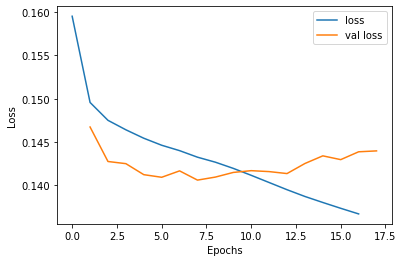

Training time: 121.16 minutes


In [6]:
model = train(
    dataset=(X_train, y_train, X_test, y_test),
    model=model,
    epochs=60,
    validation_freq=1,
    callbacks=[es, lr_schedule],
    verbose=2,
    batch_size=100,
)

# y_pred = model.predict(X_test)
# plot_roc(y_test, y_pred)
# print(auc(y_test, y_pred))

In [8]:
model.save(f"../model_saves/evals/{model.name}.h5")

In [1]:
from tensorflow.keras.models import load_model

model = load_model("../model_saves/evals/danq_FOX.h5")

In [11]:
pred = model.predict(X_test)

# ROC on each TF

/home/victor/miniconda3/envs/genetics/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


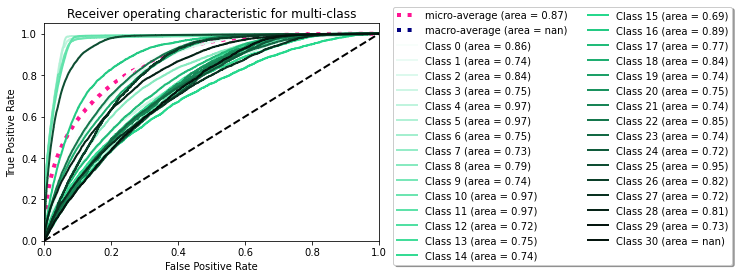

In [55]:
from sklearn.metrics import auc, roc_auc_score, roc_curve

n_classes = 31
lw = 2

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average (area = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average (area = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = ["#f8fefb",
"#eafbf4",
"#dcf9ed",
"#cef6e5",
"#c0f4de",
"#b2f1d6",
"#a4efcf",
"#96ecc8",
"#88eac0",
"#7ae7b9",
"#6de5b1",
"#5fe2aa",
"#51e0a3",
"#43dd9b",
"#35db94",
"#27d88d",
"#24ca84",
"#22bc7a",
"#1fae71",
"#1da068",
"#1a925f",
"#188456",
"#15774d",
"#136944",
"#105b3b",
"#0e4d32",
"#0b3f29",
"#093120",
"#062317",
"#04150e",
"#04150e"]
# from itertools import cycle
# colors = cycle['aqua', 'darkorange', 'cornflowerblue']

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=lw,
        color=color,
        label=f"Class {i} (area = {roc_auc[i]:.2f})",
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic for multi-class")
plt.legend(loc="upper right", bbox_to_anchor=(2.07, 1.1), shadow=True, ncol=2)
plt.show()